# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

    Контролировать добросовестность кассиров при продаже алкоголя.
Наша задача построить модель, которая по фотографии определит приблизительный возраст человека.

Метрикой качества будет MAE, модель должна выдать MAE не больше 8 лет.

В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
flow_df = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Построим гистограмму.

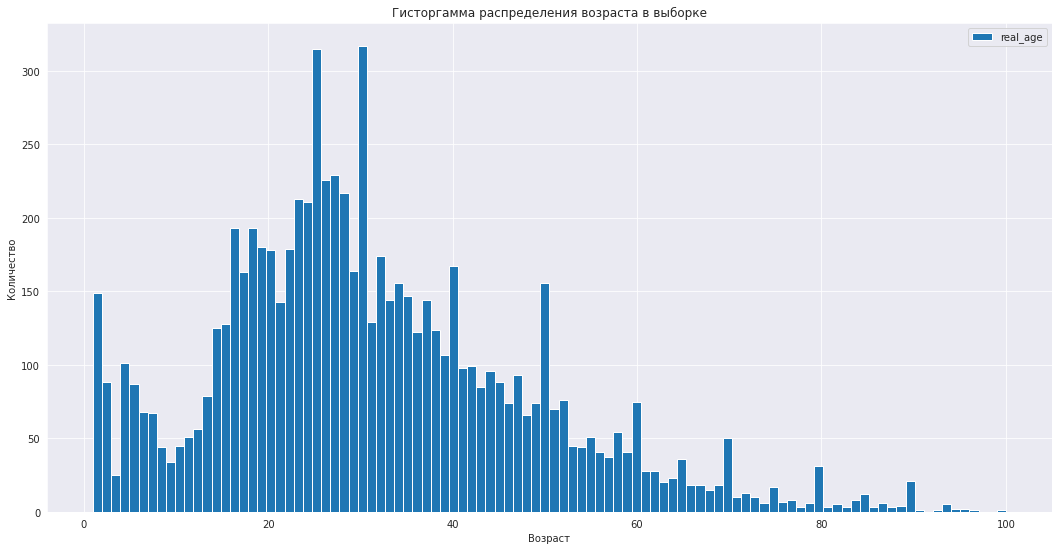

In [3]:
sns.set_style("dark")
labels.plot(kind='hist', figsize=(18,9), bins=100, grid=True)
plt.title('Гисторгамма распределения возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Посмотрим чуть ближе на начало гистограммы.

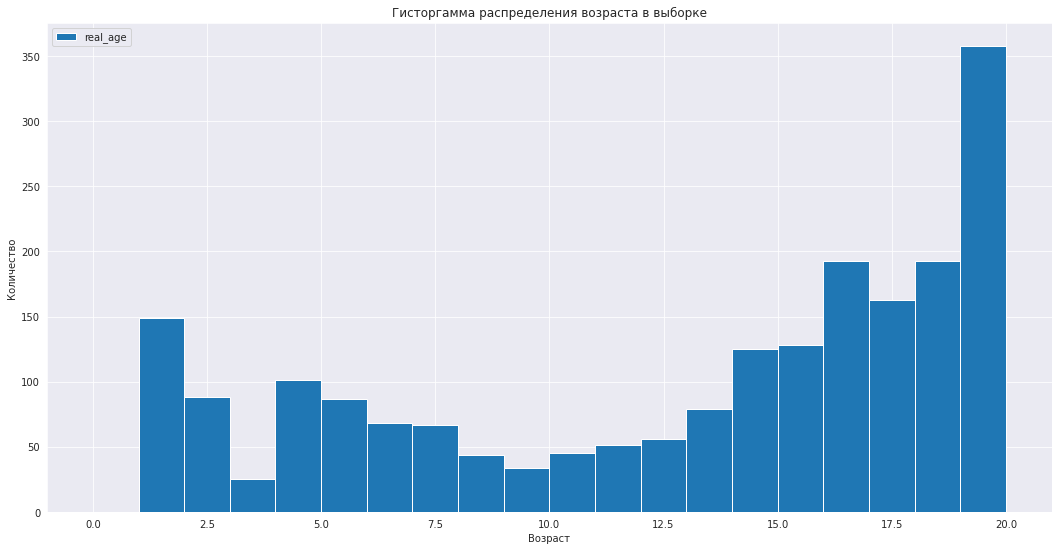

In [4]:
labels.plot(kind='hist', figsize=(18,9), bins=20, grid=True, range=(0,20))
plt.title('Гисторгамма распределения возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Посмотрим чуть ближе на середину гистограммы.

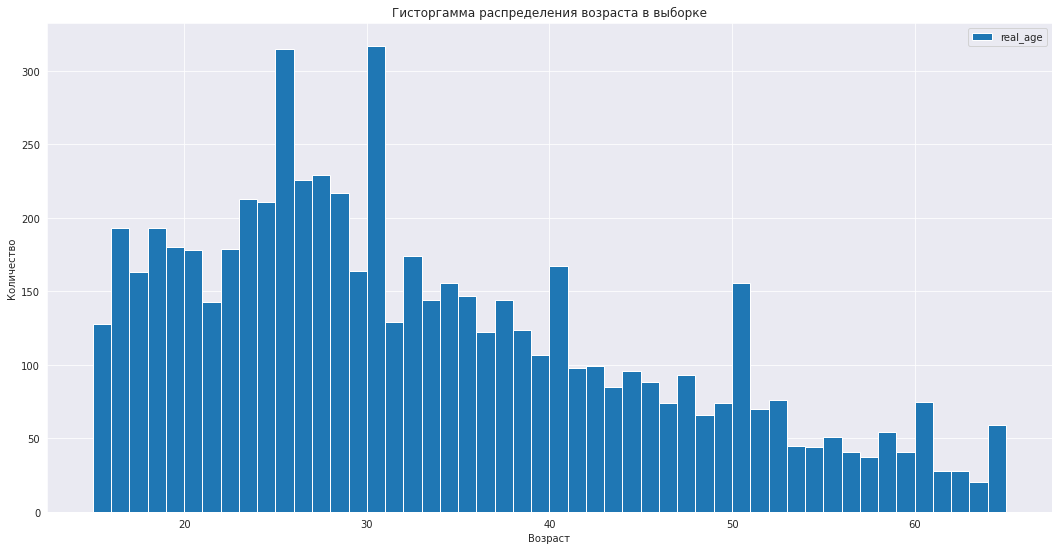

In [5]:
labels.plot(kind='hist', figsize=(18,9), bins=50, grid=True, range=(15,65))
plt.title('Гисторгамма распределения возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Построим ящик с усами.

<AxesSubplot:>

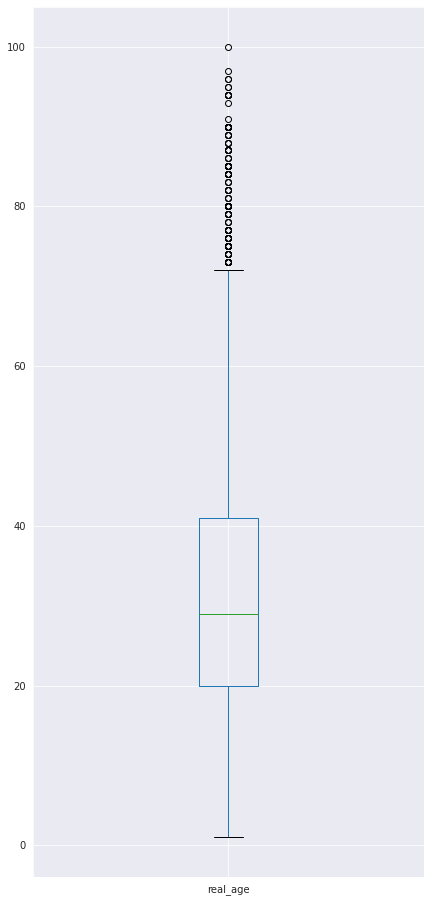

In [6]:
labels.boxplot(figsize=(7,16))

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Выведем 16 фотографий

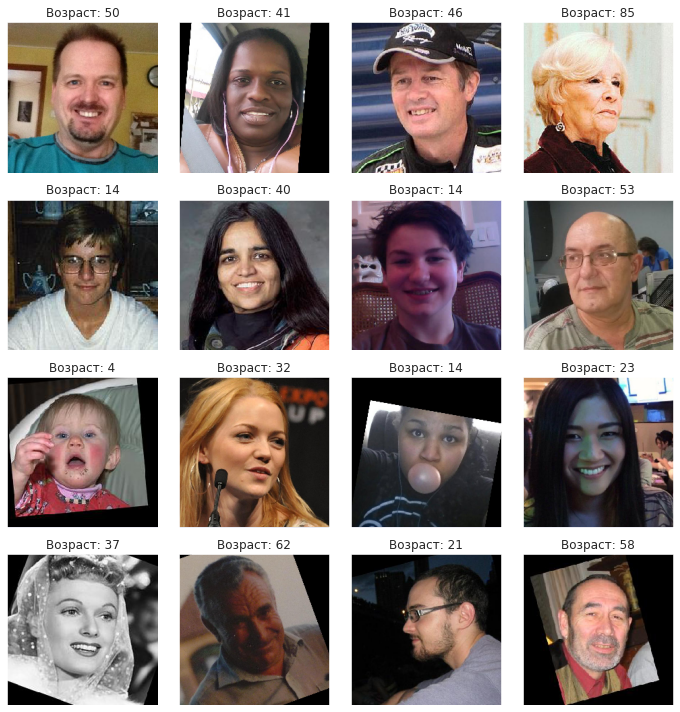

In [8]:
features, target = next(flow_df)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Возраст: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Подведём итог исследования данных**

В данных предоставленных заказчиком содержится 7591 изображение. Из просмотренных нами 16 изображений мы можем заметить что на них присутствуют фотографии лиц людей разных возрастов и рас. Сами фотографии разного качества и лица представленные на них находятся под разным углом, иногда это даже профиль лица.

В данных указан возраст людей, это целевой признак. Большая часть фотографий содержит лица людей от 20 до 41 года. Минимальный возраст равен 1 году, максимальный 100 годам.

На гистограмме также видно несколько пиков, на наш взгляд авторы данных могли либо специально собрать данные таким образом, например ориентируясь на какие-нибудь научный работы где указаны возрасты людей, в которые на лицах происходят максимально выраженные возрастные изменения. Либо при сборе данных часть изображений маркировалась исходя из предположений авторов сбора данных, так как пики часто приходятся на круглые значения, а именно такие значения обычно используют люди когда пытаются угадать возраст другого человека. 

Мы считаем данные приемлемыми для построения модели. Так как у нас есть изображения всех возрастов, а для задачи регрессии, а у нас задача регрессии, это важный элемент.

Для конкретной задачи связанной с добросовестной продажей алкоголя, в данных содержится немало фотографий подростков.

Для задачи связанной с определением возрастной группы для лучших маркетинговых предложений, данных по пенсионерам возможно не достаточно, так как часть пенсионеров попадает в усы ящика, а другая часть вообще выпадает в выбросы. Но успешность этой задачи также связана и с тем сколько групп для разных маркетинговых предложений выделяет заказчик, если это 2 группы, то данных должно быть достаточно, если больше, то возможно модели нужно больше фотографий пенсионеров.

## Обучение модели

Построим модель на основе архитектурs ResNet. Также сделаем аугментацию изображений по горизонтали. 

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import numpy as np
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/15
Successfully opened dynamic library libcublas.so.10
Successfully opened dynamic library libcudnn.so.7
356/356 - 68s - loss: 10.7176 - mae: 10.7176 - val_loss: 26.2192 - val_mae: 26.2213
Epoch 2/15
356/356 - 55s - loss: 7.4932 - mae: 7.4936 - val_loss: 9.9795 - val_mae: 9.9669
Epoch 3/15
356/356 - 68s - loss: 6.6367 - mae: 6.6372 - val_loss: 7.6841 - val_mae: 7.6883
Epoch 4/15
356/356 - 66s - loss: 6.0021 - mae: 6.0025 - val_loss: 6.1996 - val_mae: 6.2051
Epoch 5/15
356/356 - 66s - loss: 5.3684 - mae: 5.3684 - val_loss: 6.4557 - val_mae: 6.4586
Epoch 6/15
356/356 - 61s - loss: 4.9995 - mae: 4.9999 - val_loss: 6.3381 - val_mae: 6.3436
Epoch 7/15
356/356 - 66s - loss: 4.6366 - mae: 4.6362 - val_loss: 6.6233 - val_mae: 6.6213
Epoch 8/15
356/356 - 66s - loss: 4.1920 - mae: 4.1923 - val_loss: 6.1566 - val_mae: 6.1612
Epoch 9/15
356/356 - 48s - loss: 4.0223 - mae: 4.0227 - val_loss: 6.5847 - val_mae: 6.5867
Epoch 10/15
356/356 - 45s - loss: 3.7000 - mae: 3.7000 - val_loss: 6.1186 - val_mae: 6.1217
Epoch 11/15
356/356 - 48s - loss: 3.5140 - mae: 3.5140 - val_loss: 6.1183 - val_mae: 6.1276
Epoch 12/15
356/356 - 46s - loss: 3.2672 - mae: 3.2674 - val_loss: 6.0759 - val_mae: 6.0826
Epoch 13/15
356/356 - 47s - loss: 3.2776 - mae: 3.2776 - val_loss: 6.4819 - val_mae: 6.4807
Epoch 14/15
356/356 - 46s - loss: 3.0919 - mae: 3.0919 - val_loss: 6.3494 - val_mae: 6.3527
Epoch 15/15
356/356 - 46s - loss: 2.9949 - mae: 2.9946 - val_loss: 6.3390 - val_mae: 6.3460
  ...
    to  
  ['...']
119/119 - 11s - loss: 6.3390 - mae: 6.3460
Test MAE: 6.3460

```

## Анализ обученной модели

На основе данных предоставленных заказчиком, архитектуры ResNet и с использованием мощностей графического ускорителя GPU, нами была создана модель для определения возраста человека по фотографии лица.

Для увеличения данных нами была проведена аугментация данных по горизонтали, для этого в ImageDataGenerator был использован параметр horizontal_flip = True. Также у архитектуры ResNet50 был использован параметр weights = 'imagenet' (для увеличения скорости обучения в графическом ускорители GPU значения этого же параметра носит изменённое имя '/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'). Также в модели был применён алгоритм Adam со скоростью обучения lr = 0.0001. 

Для тестовой выборки было использовано 25% данных. 

Созданная модель на 15 эпохах достигла показателей метрики MAE на тестовой выборке 6.3 года, что удовлетворяет условию заказчика.
Однако, на наш взгляд применение в бизнесе данной модели может быть сомнительным. Метрика MAE всё равно остаётся высокой. 

Для задачи по контролю добросовестности продажи алкоголя кассирами модель применить можно, но учитывая погрешность модели. То есть если модель считает что возраст покупателя 24 года, то уточнить реальный возраст кассиру всё равно следует, так как вполне возможно что покупателю меньше 18. 

Для задачи рекомендации разным возрастным группам покупателей разные виды товаров, модель также имеет большой разброс по прогнозируемому возрасту. Но всё зависит от того сколько возрастных групп покупателей выделяет магазин. Если это три группы: юный возраст, средний возраст и пожилой возраст. То в таком случае модель будет корректно работать. Если же диапазон возраста группы будет меньше размера самой метрики MAE, то рекомендации модели будут не всегда корректны. 